# Inception model - Pasquet

Here, we explore the inception model [from Pasquet et al. article.](https://arxiv.org/pdf/1806.06607.pdf):

- First the regular model 
- Then the augmented model with the galacatif redenning
- Finaly, an exploration of probability ditributions as output of the model

### Packages

In [1]:
import tensorflow as tf

#Checking for GPU access
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.stats import median_abs_deviation
from tensorflow.keras.metrics import mse

from tools import *
from model_inception import *

## Data preparation

In [3]:
# data is stored in the following repo
%ls /global/cfs/cdirs/lsst/groups/PZ/valentin_image_data_temp

download  img_30k.npy  z_30k.npy


In [4]:
# Let's use here directly the two numpy files actually extracted from 'download'
img_path = '/global/cfs/cdirs/lsst/groups/PZ/valentin_image_data_temp/img_30k.npy'
z_path = '/global/cfs/cdirs/lsst/groups/PZ/valentin_image_data_temp/z_30k.npy'

img = np.load(img_path)
z = np.load(z_path)

In [5]:
# Preprocessing
scaling = []
for i in range(img.shape[-1]):
    sigma = 1.4826*median_abs_deviation(img[...,i].flatten())
    scaling.append(sigma)

img = np.arcsinh(img / scaling / 3.)

In [6]:
# Train, validation & test split
data = {}
data['train'] = [img[:15000,...], z[:15000]]
data['val'] = [img[15000:20000,...], z[15000:20000]]
data['test'] = [img[20000:,...], z[20000:]]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


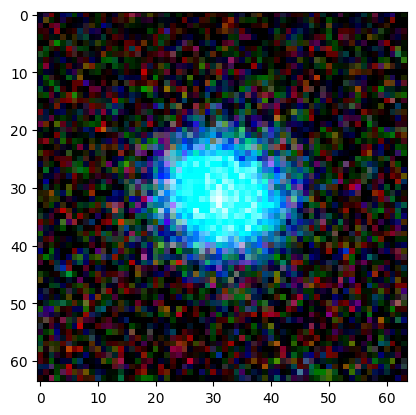

In [7]:
# Check transformed images
plt.imshow(data['train'][0][0, ..., :3]);

## Regular Model training

In [8]:
model = model_tf2()
model.compile(optimizer='adam', loss=mse)

In [9]:
#model.summary()

In [10]:
model.compile(optimizer='adam', loss=mse)

In [11]:
# Learning rate schedule
LEARNING_RATE=0.001
LEARNING_RATE_EXP_DECAY=0.9
lr_decay = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch,
    verbose=True)

# Tensoboard tracking
#tb_callback = tf.keras.callbacks.TensorBoard('./logs/inception', update_freq='batch')

model.compile(optimizer='adam', loss=mse)
history = model.fit(x = data['train'][0], 
          y = data['train'][1],
          batch_size = 64,
          validation_data=(data['val'][0], data['val'][1]),
          steps_per_epoch=len(data['train'][0])//64,
          epochs=25,
          callbacks=[lr_decay])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/25
234/234 [==============================] - 16s 35ms/step - loss: 0.0587 - val_loss: 0.0026 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/25
234/234 [==============================] - 8s 32ms/step - loss: 0.0017 - val_loss: 0.0023 - lr: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/25
234/234 [==============================] - 8s 32ms/step - loss: 0.0014 - val_loss: 0.0013 - lr: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/25
234/234 [==============================] - 8s 32ms/step - loss: 0.0011 - val_loss: 0.0011 - lr: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/25
234/234 [==============================] - 7s 32ms/step - loss: 0.0010 - val_loss: 0.0012 - lr: 6.5610e-04

Epoch 6: LearningRateSchedul

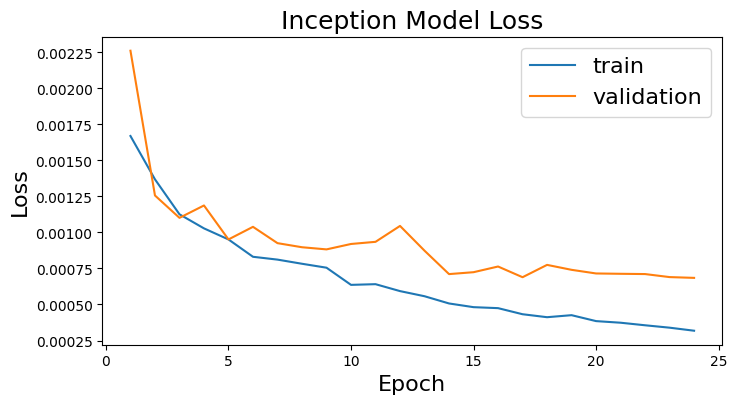

In [12]:
history_plot(history, 'Inception Model Loss')

In [13]:
# Get the prediction
preds = model.predict(data['test'][0]).squeeze()

313/313 [==============================] - 2s 6ms/step


In [14]:
# Metrics results
dz, pred_bias, smad, out_frac = metrics(data['test'][1], preds)
print_metrics(pred_bias, smad, out_frac)

Prediction bias: -0.0020


<IPython.core.display.Latex object>

Outlier fraction: 2.87%


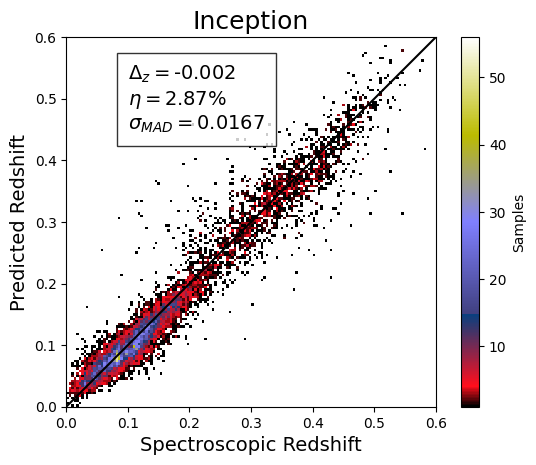

In [15]:
plot_results(data['test'][1], preds, pred_bias, out_frac, smad, 'Inception')

#### Residuals analysis

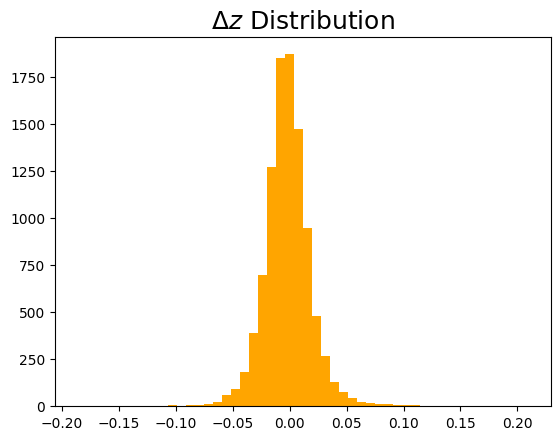

In [16]:
# Delta_z histogram
plt.hist(dz, bins=50, color='orange')
plt.title('$ \Delta z$ Distribution', fontsize=18);

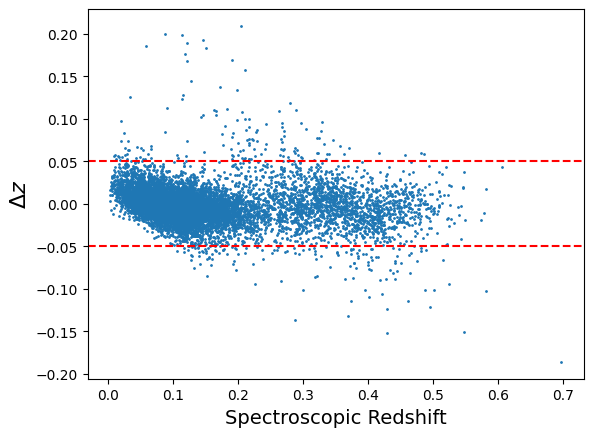

In [17]:
# Delta_z repartition with spectroscopic redshift
plt.scatter(data['test'][1], dz, s=1)
plt.axhline(0.05, color='r', linestyle='--')
plt.axhline(-0.05, color='r', linestyle='--')
plt.xlabel('Spectroscopic Redshift' , fontsize=14)
plt.ylabel('$ \Delta z$', fontsize=16);

## Same model with larger training set 

In [18]:
!ls /global/cfs/cdirs/lsst/groups/PZ/valentin_image_data_temp

download  img_30k.npy  z_30k.npy


In [19]:
data_full = np.load('/global/cfs/cdirs/lsst/groups/PZ/valentin_image_data_temp/download')

In [20]:
z = pd.DataFrame(data_full["labels"][:60000]).z

In [21]:
img = data_full["cube"][:60000]

In [22]:
scaling = []
for i in range(img.shape[-1]):
    sigma = 1.4826*median_abs_deviation(img[...,i].flatten())
    scaling.append(sigma)

img = np.arcsinh(img / scaling / 3.)

In [23]:
large_data = {}
large_data['train'] = [img[:40000,...], z[:40000]]
large_data['val'] = [img[40000:50000,...], z[40000:50000]]
large_data['test'] = [img[50000:,...], z[50000:]]

In [24]:
large_model = model_tf2()

large_model.compile(optimizer='adam', loss=mse)

In [25]:
#large_model.summary()

In [26]:
# Learning rate schedule
LEARNING_RATE=0.001
LEARNING_RATE_EXP_DECAY=0.9
lr_decay = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch,
    verbose=True)

# Tensoboard tracking
#tb_callback = tf.keras.callbacks.TensorBoard('./logs/inception', update_freq='batch')


large_history = large_model.fit(x = large_data['train'][0], 
          y = large_data['train'][1],
          batch_size = 64,
          validation_data=(large_data['val'][0], large_data['val'][1]),
          steps_per_epoch=len(large_data['train'][1])//64,
          epochs=25,
          callbacks=[lr_decay])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/25
625/625 [==============================] - 22s 32ms/step - loss: 0.0071 - val_loss: 0.0014 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/25
625/625 [==============================] - 19s 31ms/step - loss: 0.0012 - val_loss: 8.4129e-04 - lr: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/25
625/625 [==============================] - 19s 31ms/step - loss: 9.9082e-04 - val_loss: 6.7302e-04 - lr: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/25
625/625 [==============================] - 19s 31ms/step - loss: 8.6556e-04 - val_loss: 6.6325e-04 - lr: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/25
625/625 [==============================] - 19s 31ms/step - loss: 7.9171e-04 - val_loss: 6.4589e-04 - lr: 6.5610e-

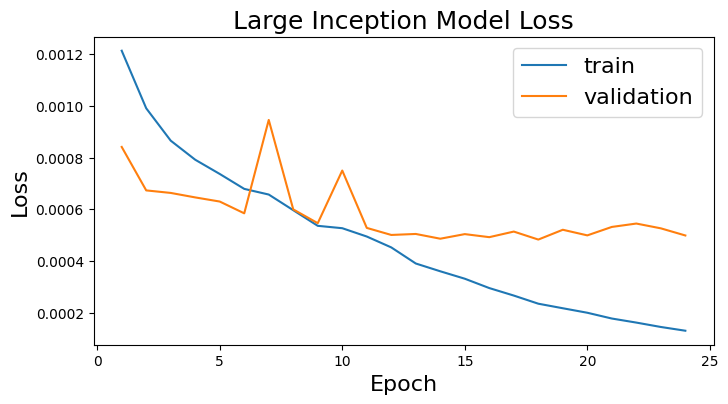

In [27]:
history_plot(large_history, 'Large Inception Model Loss')

In [28]:
# Get the predictions
preds = large_model.predict(large_data['test'][0]).squeeze()

313/313 [==============================] - 2s 6ms/step


In [29]:
dz, pred_bias, smad, out_frac = metrics(large_data['test'][1], preds)
print_metrics(pred_bias, smad, out_frac)

Prediction bias: -0.0000


<IPython.core.display.Latex object>

Outlier fraction: 2.06%


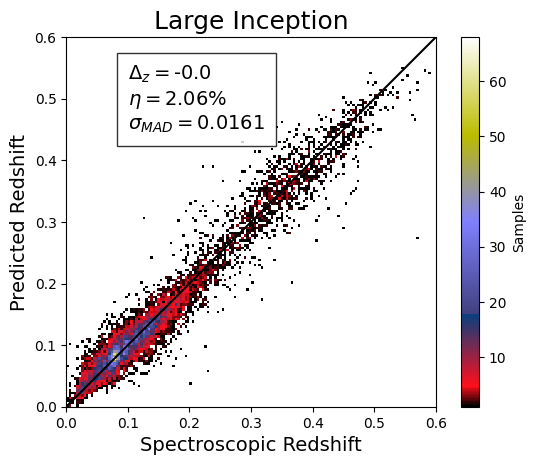

In [30]:
plot_results(large_data['test'][1], preds, pred_bias, out_frac, smad, 'Large Inception')

## Extra feature: Galactic Reddening

One can add extra features and concatenate them after the convolution part of the inception model to improve the estimated redshifts. In Pasquet's article, they propose to use the galactic redenning to do so

In [31]:
data_download = np.load('/global/cfs/cdirs/lsst/groups/PZ/valentin_image_data_temp/download')

In [32]:
cat = pd.DataFrame(data_download["labels"][:30000] )
cat.columns

Index(['imageID', 'specObjID', 'bestObjID', 'class', 'subClass', 'z', 'zErr',
       'objID', 'type', 'flags', 'ra', 'dec', 'l', 'b', 'dered_petro_u',
       'dered_petro_g', 'dered_petro_r', 'dered_petro_i', 'dered_petro_z',
       'petroMagErr_u', 'petroMagErr_g', 'petroMagErr_r', 'petroMagErr_i',
       'petroMagErr_z', 'zphot', 'dzphot', 'zphot_avg', 'zphot_reliable',
       'e_bv_sfd', 'primtarget', 'sectarget', 'targettype', 'spectrotype',
       'Column1', 'v_disp', 'release', 'bptclass', 'lgm_tot_p50',
       'sfr_tot_p50', 'specsfr_tot_p50', 'oh_p50', 'logMass_median',
       'ssfr_mean', 'age_mean', 'tau_mean', 't_age_mean', 'metallicity_mean',
       'dust1_mean', 'dust2_mean', 'EBV', 'fracDev_r', 'deVAB_r', 'deVPhi_r',
       'expAB_r', 'expPhi_r', 'petroR90_r', 'deVRad_r', 'expRad_r',
       'probPSF_r', 'extinction_u', 'extinction_g', 'extinction_r',
       'extinction_i', 'extinction_z'],
      dtype='object')

In [33]:
EBV = cat.EBV
EBV.shape

(30000,)

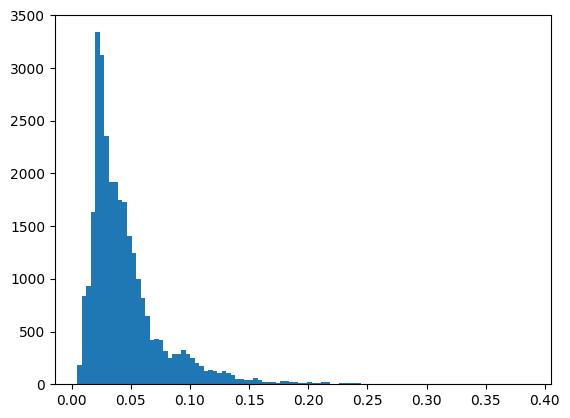

In [34]:
plt.hist(EBV, bins=100);

In [35]:
# Split into train, val and test taking 1/2, 1/4 and 1/4 respectively
EBV_train = EBV[:15000]
EBV_val = EBV[15000:20000]
EBV_test = EBV[20000:]

In [36]:
model_ebv = model_tf2(with_ebv=True)

In [37]:
model_ebv.compile(optimizer='adam', loss=mse)

In [38]:
# Learning rate schedule
LEARNING_RATE=0.001
LEARNING_RATE_EXP_DECAY=0.9
lr_decay = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch,
    verbose=True)

# Tensoboard tracking
#tb_callback = tf.keras.callbacks.TensorBoard('./logs/inception_w_EBV', update_freq='batch')

history_ebv = model_ebv.fit(x = [data['train'][0], EBV_train], 
          y = data['train'][1],
          batch_size = 64,
          validation_data=([data['val'][0], EBV_val], data['val'][1]),
          steps_per_epoch=len(data['train'][0])//64,
          epochs=25,
          callbacks=[lr_decay])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/25
234/234 [==============================] - 10s 36ms/step - loss: 0.0090 - val_loss: 0.0018 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/25
234/234 [==============================] - 8s 33ms/step - loss: 0.0014 - val_loss: 0.0014 - lr: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/25
234/234 [==============================] - 8s 32ms/step - loss: 0.0011 - val_loss: 0.0011 - lr: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/25
234/234 [==============================] - 8s 32ms/step - loss: 9.7945e-04 - val_loss: 9.1921e-04 - lr: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/25
234/234 [==============================] - 8s 33ms/step - loss: 8.8224e-04 - val_loss: 0.0012 - lr: 6.5610e-04

Epoch 6: Learnin

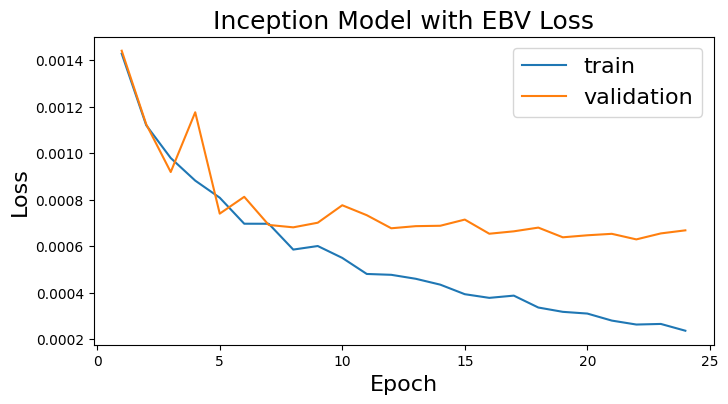

In [39]:
history_plot(history_ebv, 'Inception Model with EBV Loss')

In [40]:
# Get the predictions
preds_ebv = model_ebv.predict([data['test'][0], EBV_test]).squeeze()

313/313 [==============================] - 2s 6ms/step


In [41]:
dz, pred_bias, smad, out_frac = metrics(data['test'][1], preds_ebv)
print_metrics(pred_bias, smad, out_frac)

Prediction bias: 0.0049


<IPython.core.display.Latex object>

Outlier fraction: 3.01%


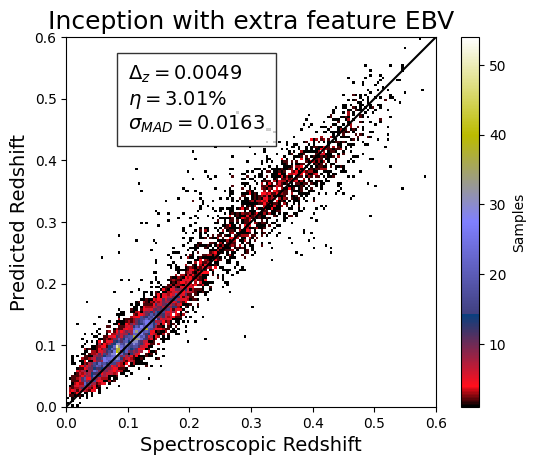

In [42]:
plot_results(data['test'][1], preds_ebv, pred_bias, out_frac, smad, 'Inception with extra feature EBV')

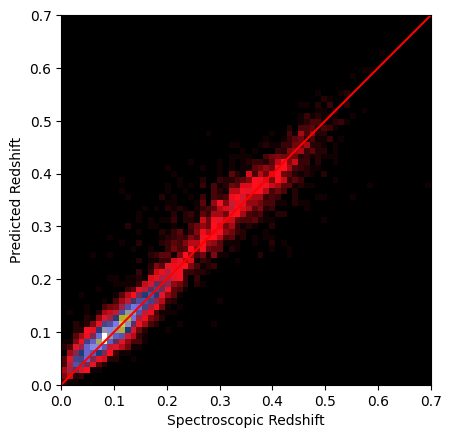

In [43]:
plt.hist2d(data['test'][1], preds_ebv, 64, range=[[0,0.7],[0,0.7]], cmap='gist_stern'); 
plt.gca().set_aspect('equal');
plt.plot([0,0.7],[0,0.7],color='r')
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Predicted Redshift');

## Probability Distribitions Output 

In [44]:
model = model_tf2(output_distrib=True)

In [45]:
negloglik = lambda y, p_y: -p_y.log_prob(y)
model.compile(optimizer='adam', loss=negloglik)

In [46]:
#model.summary()

In [47]:
# Learning rate schedule
LEARNING_RATE=0.001
LEARNING_RATE_EXP_DECAY=0.9
lr_decay = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch,
    verbose=True)

# Tensoboard tracking
#tb_callback = tf.keras.callbacks.TensorBoard('./logs/inception', update_freq='batch')



history = model.fit(x = data['train'][0], 
              y = data['train'][1],
              batch_size = 64,
              validation_data=(data['val'][0], data['val'][1]),
              steps_per_epoch=len(data['train'][0])//64,
              epochs=10,
              callbacks=[lr_decay])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
234/234 [==============================] - 12s 37ms/step - loss: -1.5838 - val_loss: -1.8176 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/10
234/234 [==============================] - 8s 33ms/step - loss: -1.8937 - val_loss: -2.0062 - lr: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/10
234/234 [==============================] - 8s 33ms/step - loss: -2.0408 - val_loss: -2.1168 - lr: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/10
234/234 [==============================] - 8s 33ms/step - loss: -2.1463 - val_loss: -2.0689 - lr: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/10
234/234 [==============================] - 8s 33ms/step - loss: -2.2087 - val_loss: -1.9957 - lr: 6.5610e-04

Epoch 6: LearningR

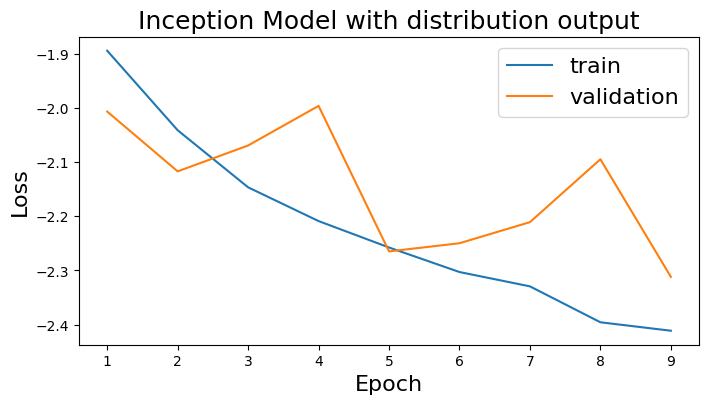

In [48]:
history_plot(history, 'Inception Model with distribution output')

In [49]:
# Beware: differences between model() and model.predict()
# The first gives a distribution and the second an array

yhat = model(np.reshape(data['test'][0][0], (1, 64, 64, 5)))
assert isinstance(yhat, tfd.Distribution)

yhat_ = model.predict(np.reshape(data['test'][0][0], (1, 64, 64, 5)))
assert isinstance(yhat_, np.ndarray)

1/1 [==============================] - 1s 590ms/step


But what we want here are distributions as outputs and not just arrays. So we need to use the call method from model and the predict method. The problem is that with the call methods, memory issues can arise. For this reason, the predictions need to be performed on batched and not on the full test set at once.

In [50]:
# List of batch of distributions by calling the model on batches of images
preds_distrib = []
batch_size = 1000
start = 0
length = len(data['test'][0])
while start + batch_size <length:
    preds_distrib.append(model(np.reshape(data['test'][0][start:start+batch_size], (batch_size, 64, 64, 5))))
    start += batch_size
preds_distrib.append(model(np.reshape(data['test'][0][start:], (length - start, 64, 64, 5))))

In [51]:
preds_distrib

[<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1000] event_shape=[1] dtype=float32>,
 <tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1000] event_shape=[1] dtype=float32>,
 <tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1000] event_shape=[1] dtype=float32>,
 <tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1000] event_shape=[1] dtype=float32>,
 <tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1000] event_shape=[1] dtype=float32>,
 <tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1000] event_shape=[1] dtype=float32>,
 <tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1000] event_shape=[1] dtype=float32>,
 <tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1000] event_shape=[1] dtype=float32>,
 <tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1000] event_shape=[1] dtype=float32>,
 <tfp.distributions._TensorCoercible 

The goal is to be able to have the predicted distributions directly on the whole test set

It is not the case yet, so rest of the code is with 'preds', which is just a sample of the predictions

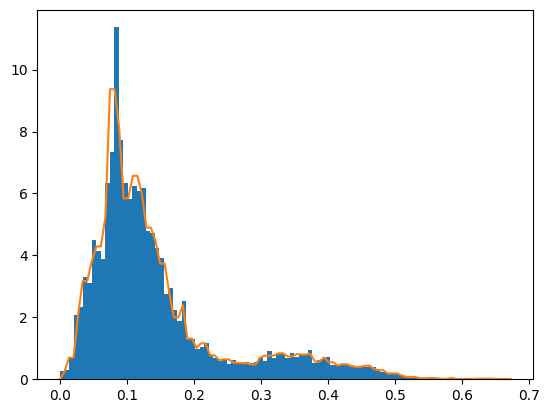

In [52]:
# Calculate the prior

import scipy.stats
hist = np.histogram(data['train'][1], 64)
prior = scipy.stats.rv_histogram(hist)

plt.hist(data['train'][1], 100, density=True);
x = np.linspace(0, data['train'][1].max(), 100)
plt.plot(x, prior.pdf(x));

In [53]:
# This returns the distribution q(z | x) for all clusters
z = np.linspace(0,0.7,100)
logps = []
logps_local = []
for i in range(len(z)):
    for k in range(len(preds_distrib)):
        logps_local.append(preds_distrib[k].log_prob(z[i]).numpy())
    ## Here flatten the list
    flat_list = []
    for sublist in logps_local:
        for item in sublist:
            flat_list.append(item)
    logps.append(flat_list)
    logps_local = []
logps = np.stack(logps)

The posterior can be ploted under the training prior or under a flat prior by dividing the posterior by the prior.

/tmp/ipykernel_723872/3077451110.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(z, np.exp(logps[:,i])/prior.pdf(z), label='posterior under flat prior')
/tmp/ipykernel_723872/3077451110.py:4: RuntimeWarning: invalid value encountered in divide
  plt.plot(z, np.exp(logps[:,i])/prior.pdf(z), label='posterior under flat prior')


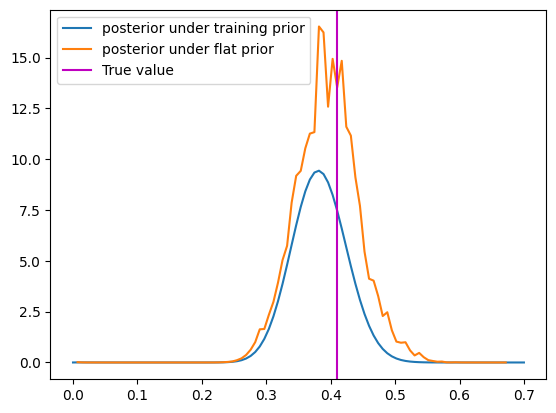

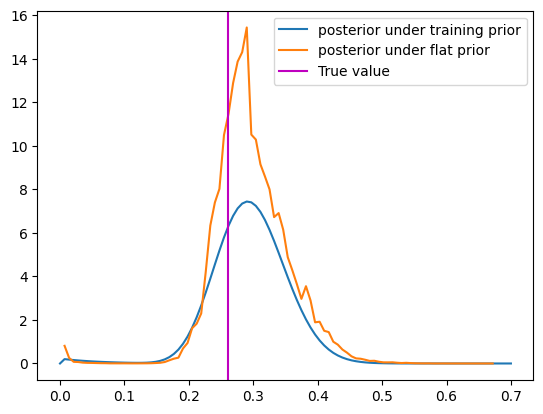

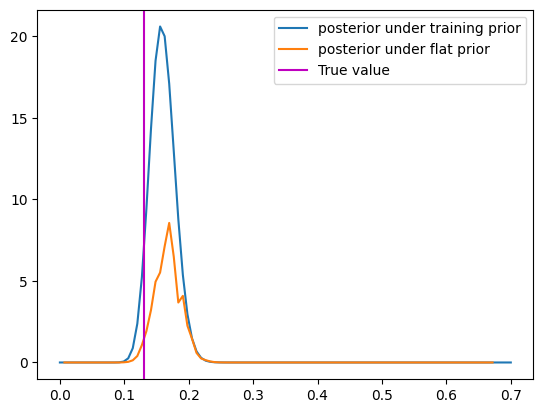

In [54]:
for i in range(3):
    plt.figure()
    plt.plot(z, np.exp(logps[:,i]), label='posterior under training prior')
    plt.plot(z, np.exp(logps[:,i])/prior.pdf(z), label='posterior under flat prior')
    plt.axvline(data['test'][1][i], color='m', label='True value')
    plt.legend()

To evalute the results of distribution outputs, we can try to extract a point estimate of them and compare with previous results: 
- Mean 
- Mode

#### Mean 

In [55]:
# With training prior
mean_preds = np.squeeze([preds_distrib[k].mean() for k in range(10)]).flatten()

In [56]:
dz, pred_bias, smad, out_frac = metrics(data['test'][1], mean_preds)
print_metrics(pred_bias, smad, out_frac)

Prediction bias: -0.0018


<IPython.core.display.Latex object>

Outlier fraction: 3.27%


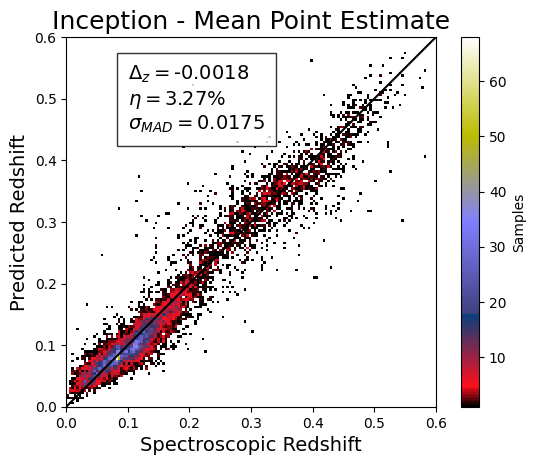

In [57]:
plot_results(data['test'][1], mean_preds, pred_bias, out_frac, smad, 'Inception - Mean Point Estimate')

#### Mode 

In [58]:
# With training prior
mode_preds = z[np.exp(logps).argmax(axis=0)]

In [59]:
dz, pred_bias, smad, out_frac = metrics(data['test'][1], mode_preds)
print_metrics(pred_bias, smad, out_frac)

Prediction bias: -0.0052


<IPython.core.display.Latex object>

Outlier fraction: 3.64%


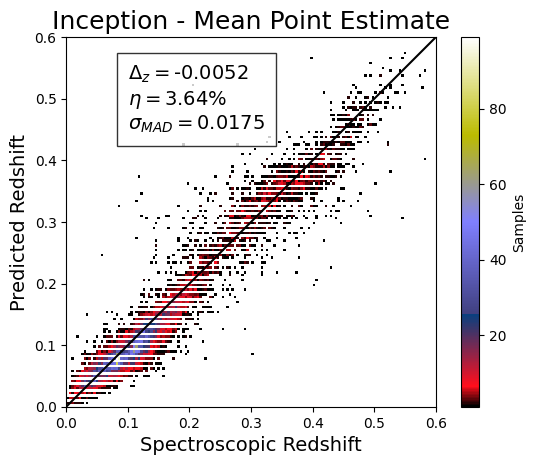

In [60]:
plot_results(data['test'][1], mode_preds, pred_bias, out_frac, smad, 'Inception - Mean Point Estimate')